# Digital Image Processing - Assignment 2

**Imports**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**Utility functions from Assignment-1**

In [2]:
def pascal_row(k):
    ans = [1]
    for row in range(1, k):
        ans = ans[1:] + ans[:-1]
        ans = np.concatenate(([1], ans, [1]))
    return np.array(ans)


def approx1DGaussFilter1(k):
    gg = np.array([pascal_row(k)])
    gg = gg.T@gg
    gg = gg/np.sum(gg)
    return gg


# util function to get gray-scale image from RGB image
def convert_to_grey(image1):
    blue_channel  = image1[:,:,0]
    green_channel = image1[:,:,1]
    red_channel   = image1[:,:,2]
    # Taking intensity value as a weighted sum of RGB
    grey_img = 0.3*red_channel + 0.59*green_channel + 0.11*blue_channel
    grey_img = np.stack((grey_img,)*3, axis=-1)
    grey_img = grey_img.astype(int)
    return grey_img


def gauss_2D(x, y, std):
    return np.exp(-(x*x+y*y)/(2*std*std))/np.sqrt(2*np.pi*std*std)


def gaussKernelGenerator(k, var):
    res = np.zeros((k, k))
    std = np.sqrt(var)
    for x in range(k):
        for y in range(k):
            res[x][y] += gauss_2D(x-(k//2), y-(k//2), std)
    res = res/np.sum(res)
    return res


def padded_img(img, k):
    [ogh, ogw] = img.shape
    sz = k//2
    gg = np.zeros((img.shape[0] + 2*sz, img.shape[1] + 2*sz))
    gg[sz:sz+ogh,sz:sz+ogw] = img
    return gg


def convolve(img, kernel):
    img = img.astype(np.float64)
    kernel = kernel.astype(np.float64)
    k = kernel.shape[0]
    img = img[:, :, 0]
    res = np.zeros((img.shape[0], img.shape[1]))
    img = padded_img(img, k)
    for x in range(res.shape[0]):
        for y in range(res.shape[1]):
            res[x][y]+= max(0, np.sum(img[x:x+k,y:y+k]*kernel))
    res = res.astype(np.int)
    return res

### 1. Blurry Moments

In [3]:
def high_boost_filter(img, size):
    kernel = approx1DGaussFilter1(5)
    demn = convolve(img, kernel)
    img = img[:,:,0]
    details = img-demn
    res = img+details
    res = np.clip(res, a_min=0, a_max=255)
    return res

def unsharp_masking(img, size):
    kernel = np.full((size, size), -1)
    kernel[size//2][size//2] = size*size-1
    demn = convolve(img, kernel)
    img = img[:,:,0]
    res = img+demn
    res = res.astype(np.float64)
    res = 255.0 * (res-np.min(res))/(np.max(res)-np.min(res))
    res = res.astype(np.uint8)
    return res

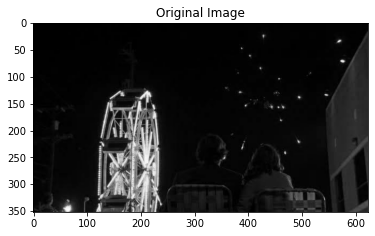

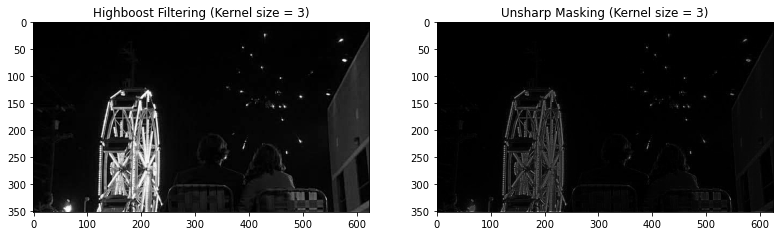

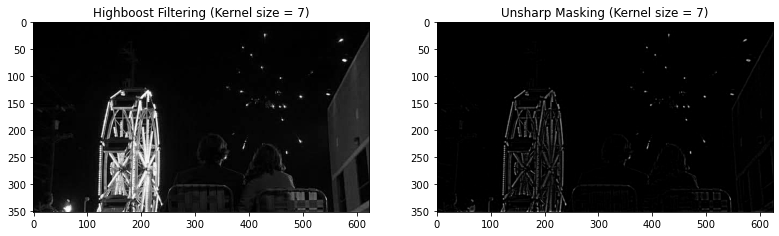

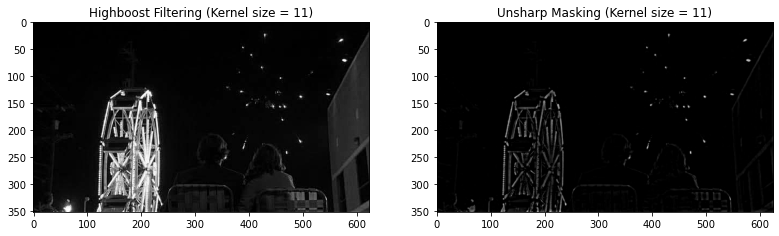

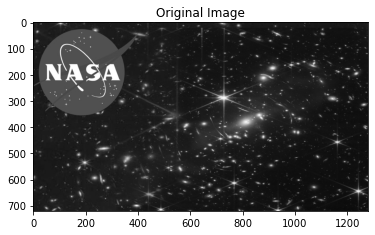

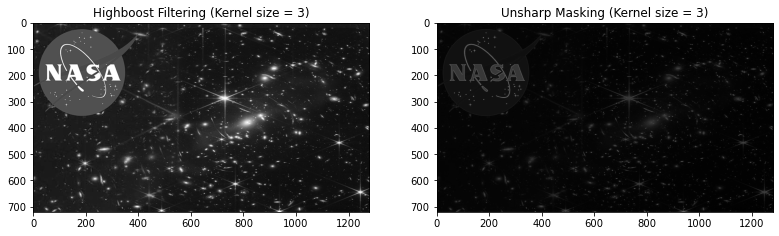

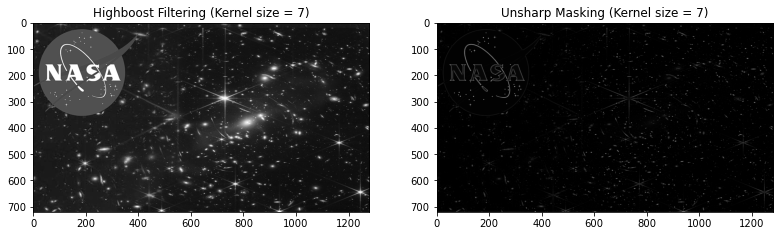

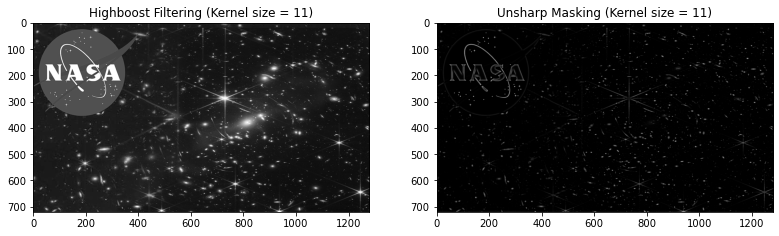

In [4]:
images = ['../images/Jam.jpg', '../images/webb.jpg']

for image in images:

    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    grey_img = convert_to_grey(img)
    plt.imshow(grey_img)
    plt.title("Original Image")
    plt.show()

    filter_sizes = [3, 7, 11]

    for size in filter_sizes:
        f, ax = plt.subplots(1, 2, figsize=(13.25, 7))
        ax[0].imshow(high_boost_filter(grey_img, size), cmap='gray')
        ax[0].set_title(f"Highboost Filtering (Kernel size = {size})")
        ax[1].imshow(unsharp_masking(grey_img, size), cmap='gray')
        ax[1].set_title(f"Unsharp Masking (Kernel size = {size})")
        plt.show()

**Alternate solution**  
  
Instead of separately computing the double derivative or smoothened image, we can directly convolve with the filter structure described below:
<br></br>
<img src="../images/Q1.png" width="512">

In [5]:
def sharpen_img(img, A, size):
    kernel = np.full((size, size), -1)
    kernel[size//2][size//2] = A*size*size-1
    return convolve(img, kernel)

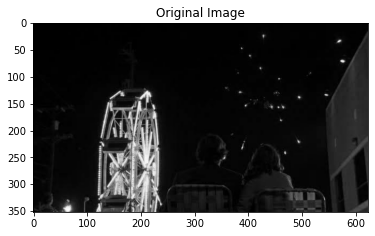

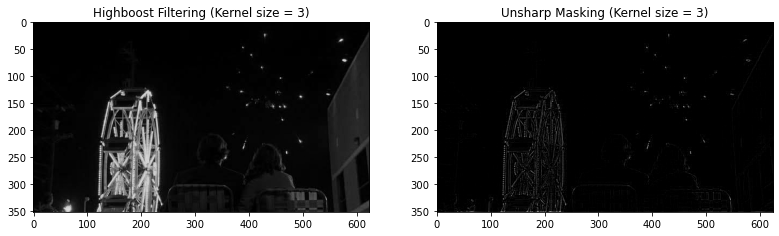

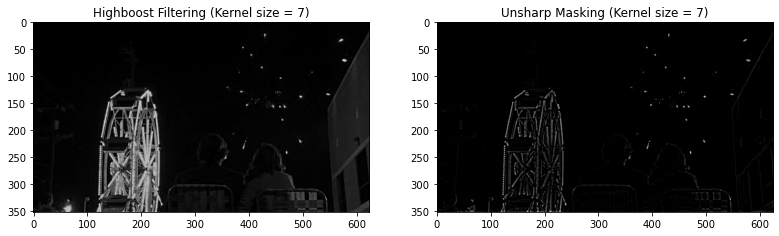

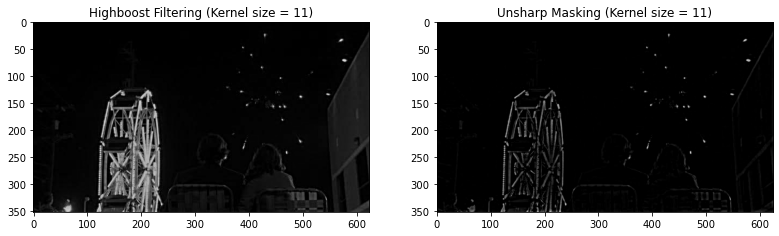

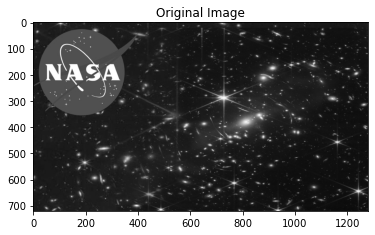

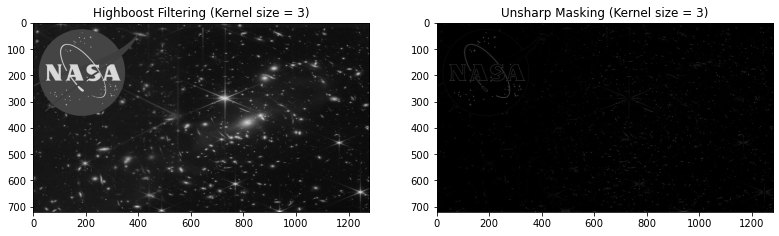

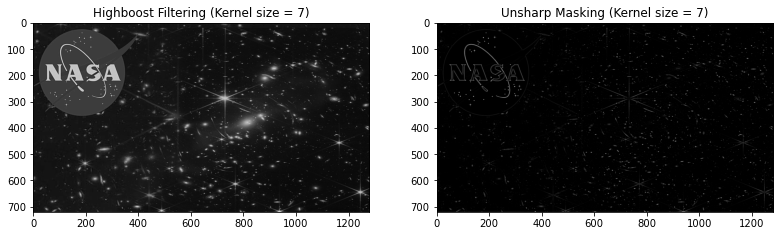

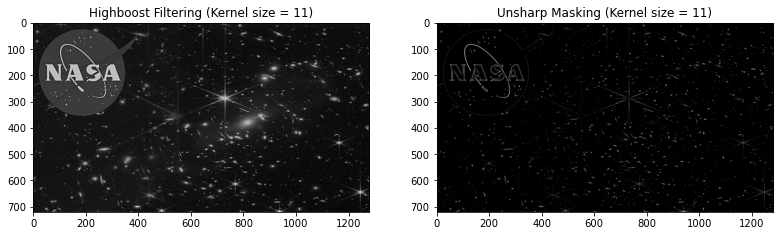

In [6]:
images = ['../images/Jam.jpg', '../images/webb.jpg']

for image in images:

    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    grey_img = convert_to_grey(img)
    plt.imshow(grey_img)
    plt.title("Original Image")
    plt.show()

    filter_sizes = [3, 7, 11]

    for size in filter_sizes:
        f, ax = plt.subplots(1, 2, figsize=(13.25, 7))
        ax[0].imshow(sharpen_img(grey_img, 3, size), cmap='gray')
        ax[0].set_title(f"Highboost Filtering (Kernel size = {size})")
        ax[1].imshow(sharpen_img(grey_img, 1, size), cmap='gray')
        ax[1].set_title(f"Unsharp Masking (Kernel size = {size})")
        plt.show()

### 2. Intentionally Blurry Moments

In [7]:
def padded_rgb(img, k):
    sz = k//2
    img = cv2.resize(img, (img.shape[1]+2*sz, img.shape[0]+2*sz), interpolation = cv2.INTER_AREA)
    plt.show()
    return img

def bilateral_filter(img, sigma_c, sigma_s, k):
    
    res = np.zeros((img.shape))
    img = padded_rgb(img, k)
    gaussian_kernel = gaussKernelGenerator(k, sigma_c**2)
    img = img.astype(np.float64)
    
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            for ch in range(res.shape[2]):
                subpart = img[i: i+k, j: j+k, ch]
                photometric_kernel = np.exp(-((subpart - img[i][j][ch])**2)/(2*sigma_s*sigma_s))
                kernel = gaussian_kernel * photometric_kernel
                res[i][j][ch] = np.sum(subpart*kernel) / np.sum(kernel)
    
    res = res.astype(np.uint8)
    return res

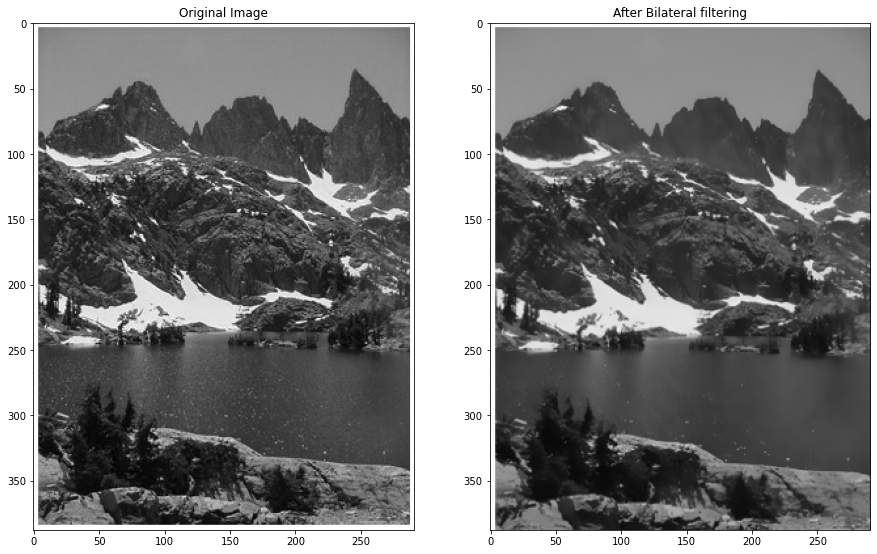

In [8]:
img = cv2.imread('../images/lakeside.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grey_img = convert_to_grey(img)
grey_img = grey_img.astype(np.uint8)

demn = bilateral_filter(grey_img, 9, 11, 7)

f, ax = plt.subplots(1, 2, figsize=(15, 30))
ax[0].imshow(grey_img, cmap='gray')
ax[0].set_title(f"Original Image")
ax[1].imshow(demn, cmap='gray')
ax[1].set_title(f"After Bilateral filtering")
plt.show()

### 3. Pam and Graphic Design

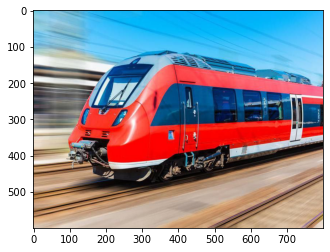

In [11]:
img = cv2.imread('../images/Q3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

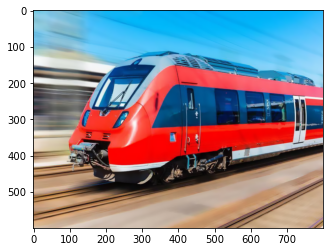

In [14]:
hehe = bilateral_filter(img, 11, 11, 11)
plt.imshow(hehe)
plt.show()